Finds the best dynamic NN model, and saves all models to h5 files.

In [1]:
%run ../MLHCExperiment-Common-Val17Test18.ipynb

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
all_visits = read_data()
all_visits = all_visits.where(all_visits["AdjCount"] > 0).dropna()

In [3]:
epochs = 1000
patience = 10
trials = 1


models = dict()
models["64-64"] = build_nn_model # 64-64
models["64-32"] = build_nn_model1 # 64-32
models["64-16"] = build_nn_model2 # 64-16
models["32-32"] = build_nn_model3 # 32-32
models["32-16"] = build_nn_model4 # 32-16
models["32-8"] = build_nn_model5 # 32-8

In [4]:
def run_dynamic_nn(model, name, features, label, epochs, patience, trials):
    print(name)
    X = all_visits[features]
    y = all_visits[label]

    mses = list()
    val_mses = list()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error',
                                               patience=patience, restore_best_weights=True)
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_for_baseline_and_nn(X, y)
    
    for j in range(trials):
        print("Trial %d" % (j + 1))
        start = time.time()
        predictions = list()

        mod = model(X_train)
        history = mod.fit(X_train, y_train.values, epochs=epochs, shuffle=False,
                            validation_data=[X_val, y_val.values], verbose=0,
                            callbacks=[PrintDot(), early_stop])
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch 
        plot_history(hist)
        
        
        # serialize weights to HDF5
        model_name = name + "-Trial" + str(j) + "-" + str(time.time()) + ".h5"
        mod.save_weights(model_name)
        
        val_mses.append(min(history.history["val_mean_squared_error"]))
        
        y_pred = mod.predict(X_test, batch_size=1)
        mses.append(mean_squared_error(y_pred, y_test))
        end = time.time()
        print("Trial completed in %.2f s" % (end - start))
        print("Average MSE so far: %.3f (%.3f)" % (np.mean(mses), np.std(mses)))
    
    print("MSEs:")
    print_mse_metrics(mses)
    print("Val MSEs:")
    print_mse_metrics(val_mses)
    fig, ax = plt.subplots(figsize=(15,7))
    ax.set(title=name, xlabel='Date', ylabel='Sick Visits Per FTE')
    all_visits.loc[TEST_START:, label].plot(ax=ax, color='gray', style='.', label='actual sick visits/fte')
    plt.scatter(all_visits.loc[TEST_START:].index, y_pred, color='r',label='predicted sick visits/fte')
    plt.legend()
    return val_mses, mses, y_pred

64-64
Dynamic-NN-AllVisits-64-64
Trial 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
.............Trial completed in 69.37 s
Average MSE so far: 1.366 (0.000)
Trial 2

....................................................................................................
...........................................................................................Trial completed in 60.08 s
Average MSE so far: 1.369 (0.002)
Trial 3

....................................................................................................
................................................................................................Trial completed in 62.04 s
Average MSE so far:

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Trial completed in 89.13 s
Average MSE so far: 1.375 (0.018)
MSEs:
MSE and RMSE over 10 trials with standard deviation in parentheses
Average MSE: 1.375 (0.018)
Average RMSE: 1.173 (0.008)
Val MSEs:
MSE and RMSE over 10 trials with standard deviation in parentheses
Average MSE: 0.806 (0.008)
Average RMSE: 0.898 (0.004)
[0.80810976, 0.7936362, 0.81472886, 0.811517, 0.80047566]
Best model 64-64
Min Val MSE 0.805
64-16
Dynamic-NN-AllVisits-64-16
Trial 1

....................................................................................................
....................................................................................................
...............................................................Trial completed in 83.45 s
Average MSE so far: 1.400 (0.000)
Trial 2

....................................................................................................
....................................................................................................
.......


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................................................................................Trial completed in 217.57 s
Average MSE so far: 1.469 (0.000)
Trial 2

....................................................................................................
....................................................................................................
....................................................................................................
..........................

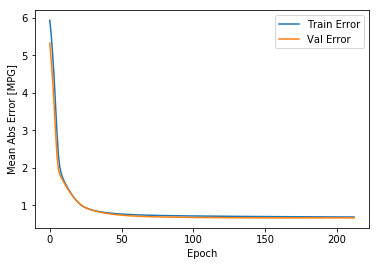

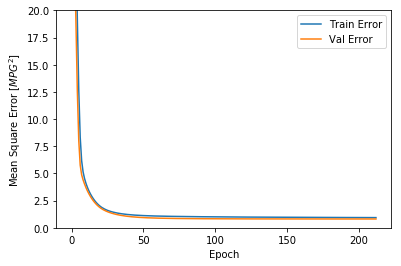

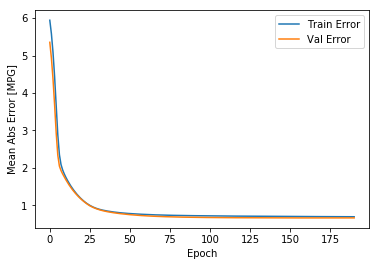

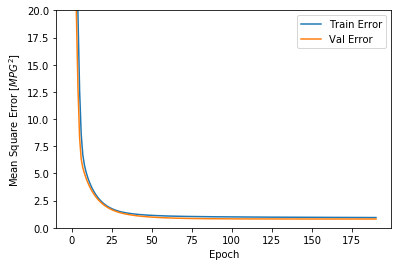

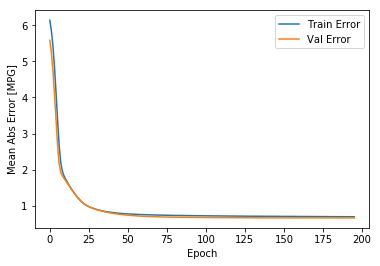

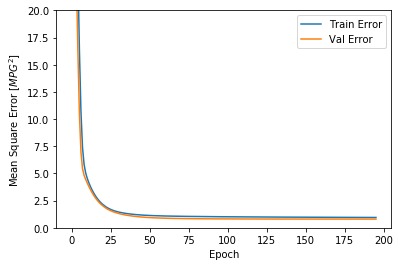

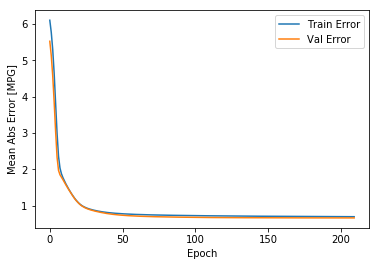

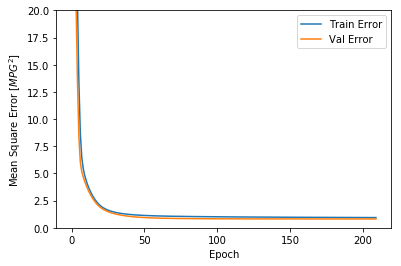

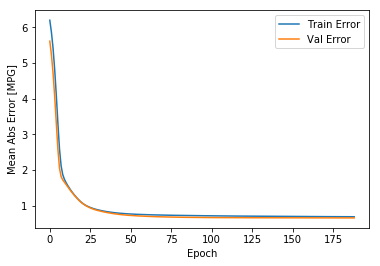

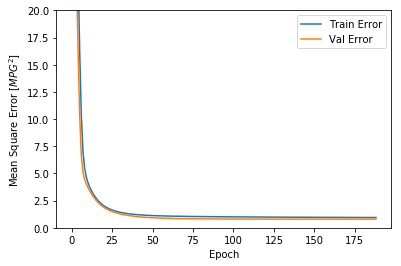

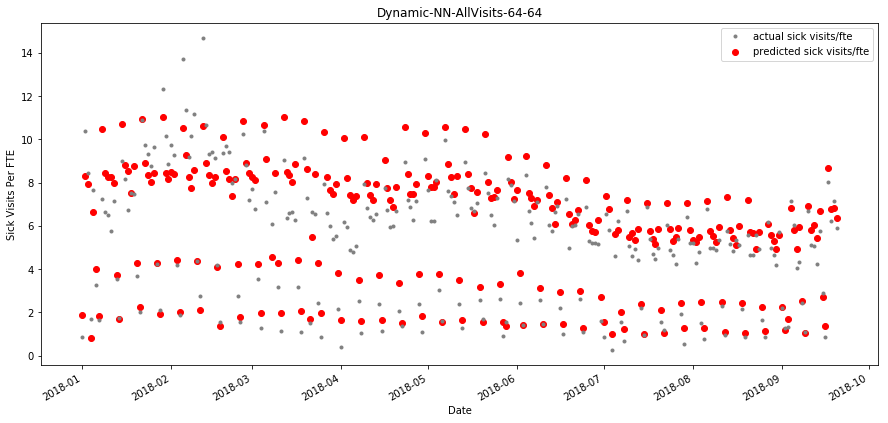

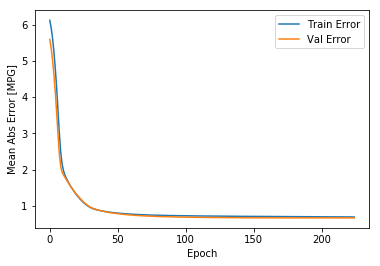

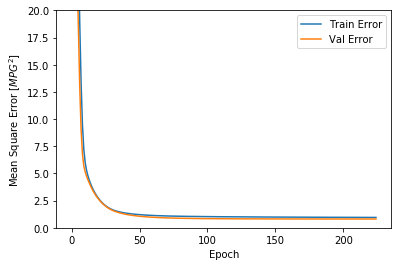

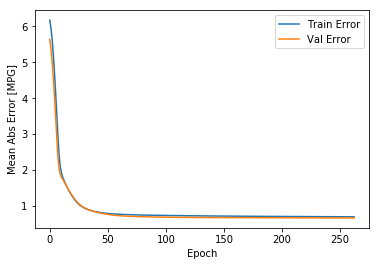

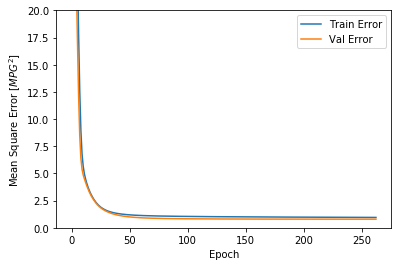

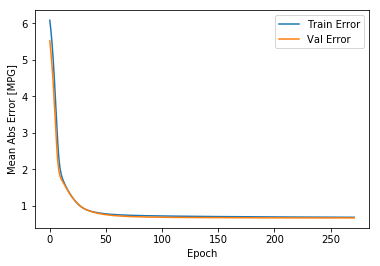

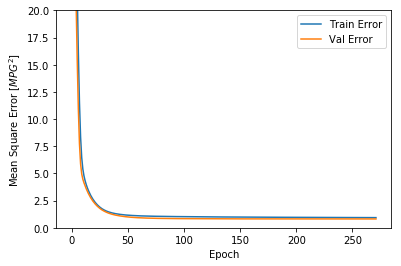

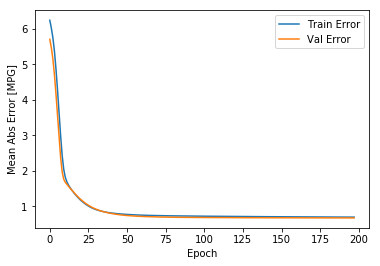

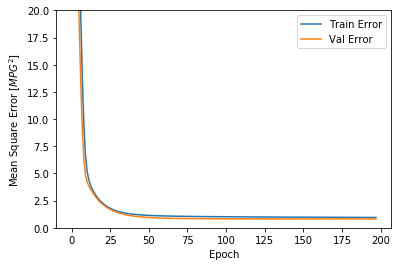

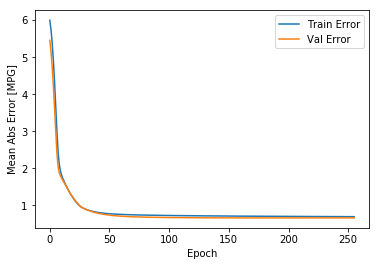

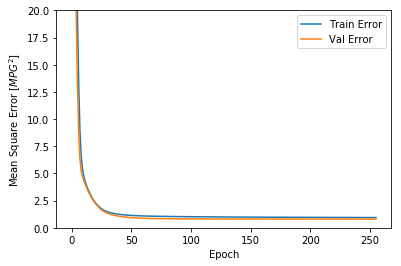

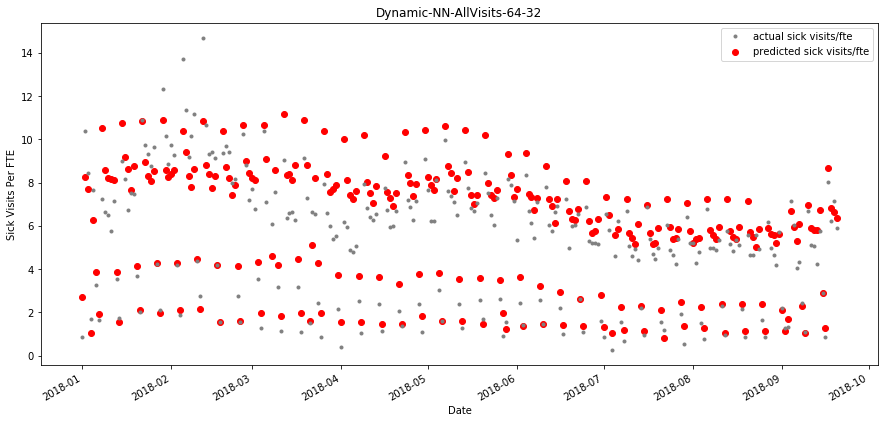

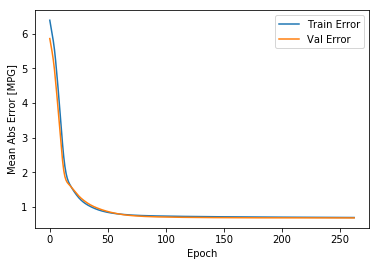

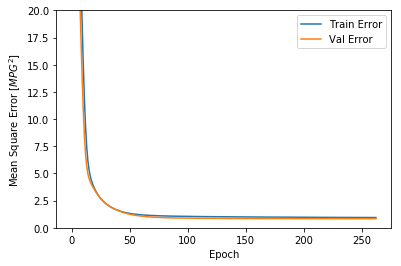

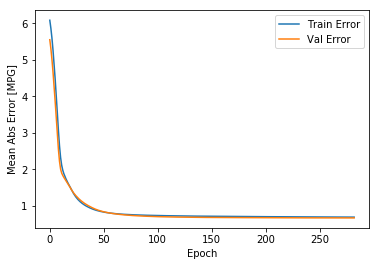

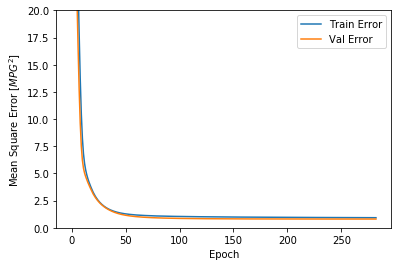

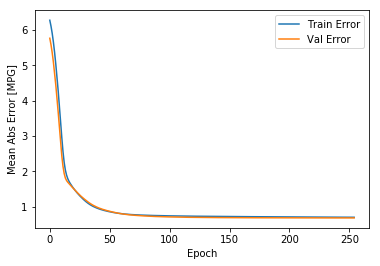

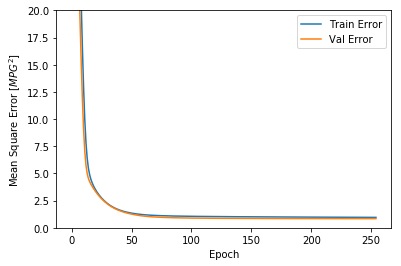

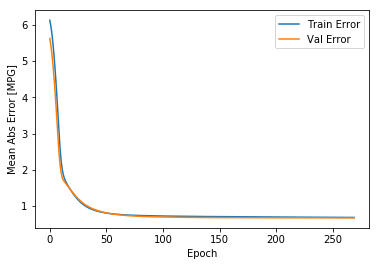

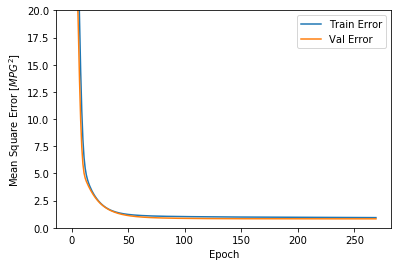

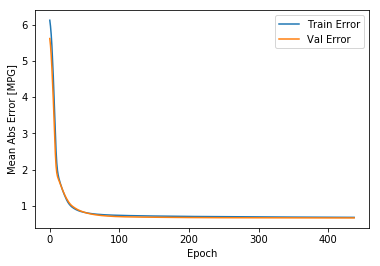

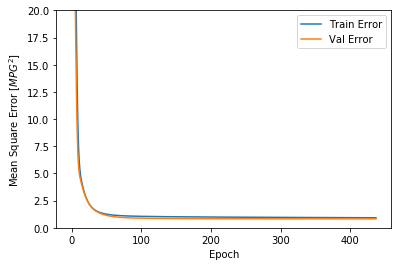

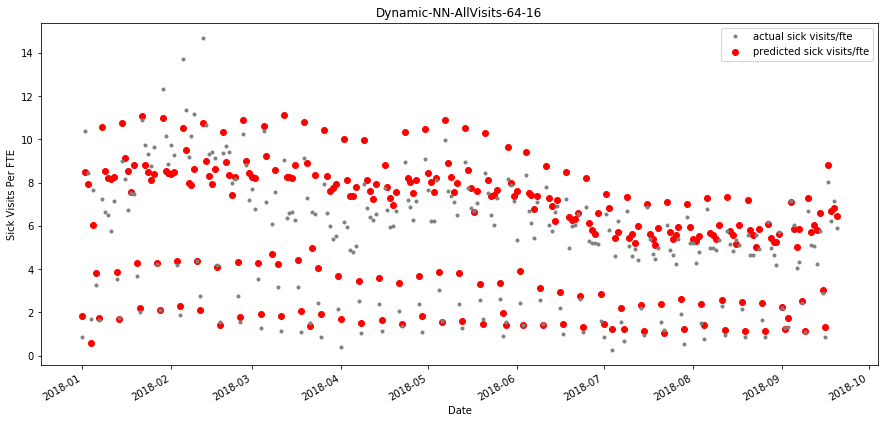

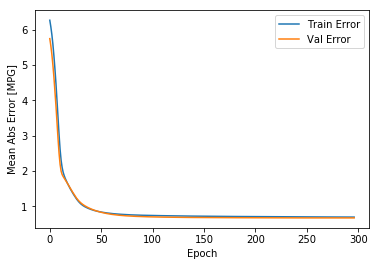

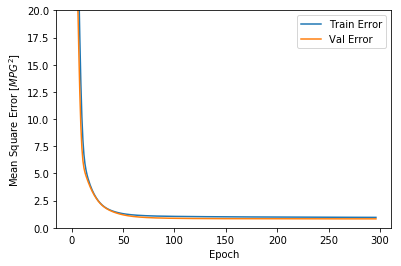

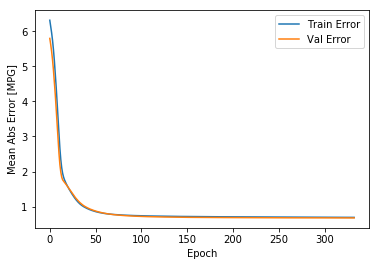

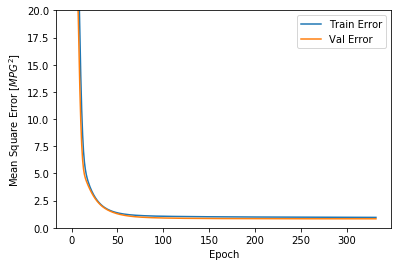

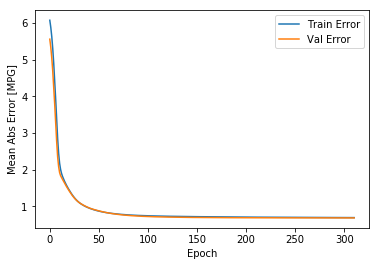

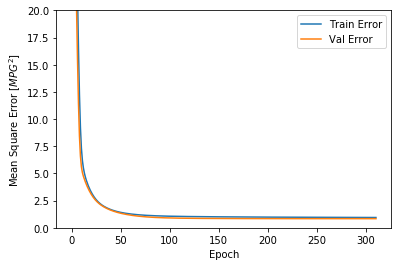

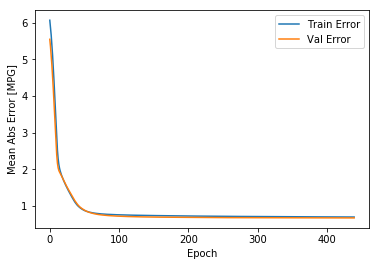

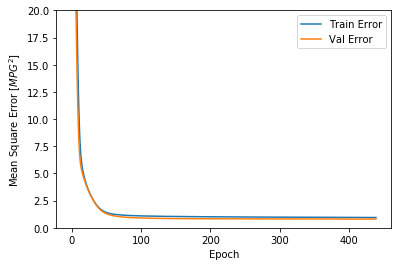

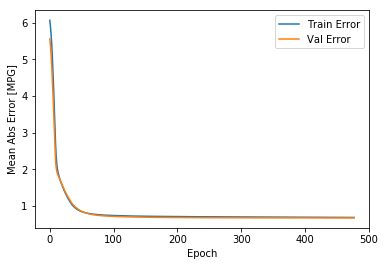

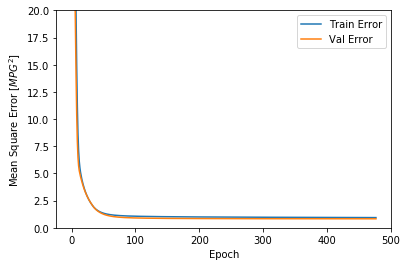

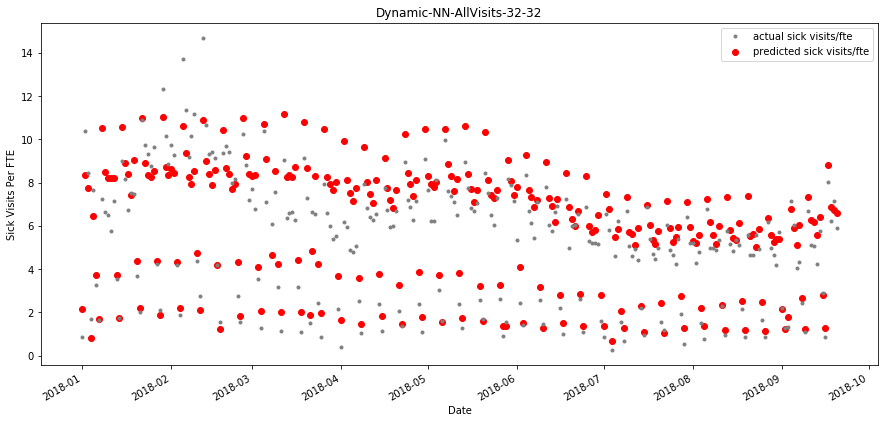

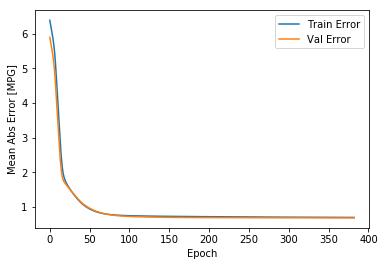

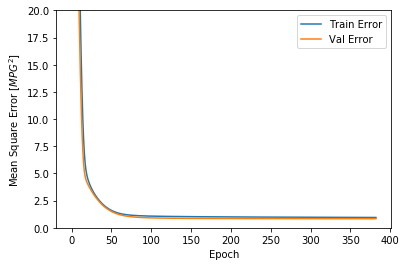

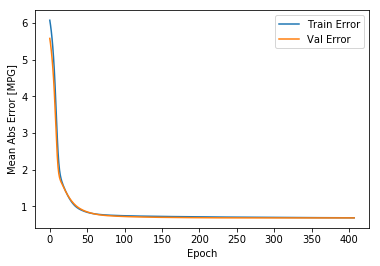

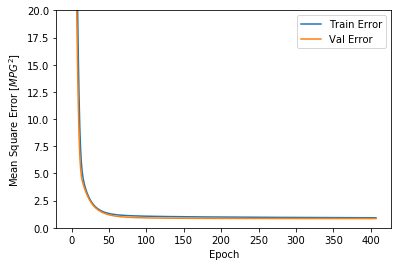

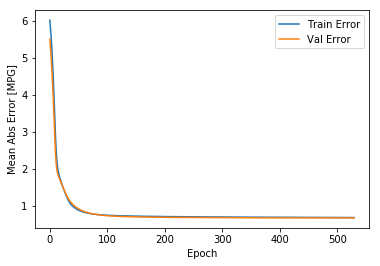

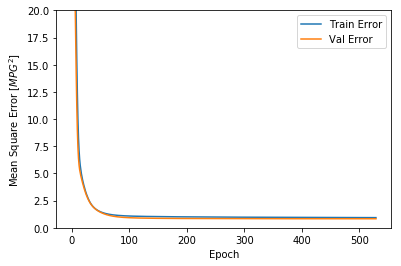

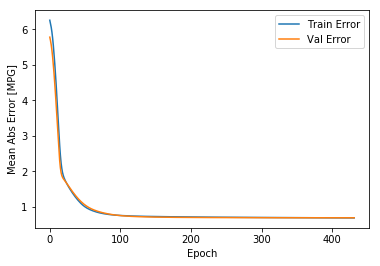

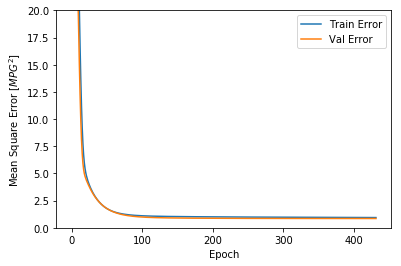

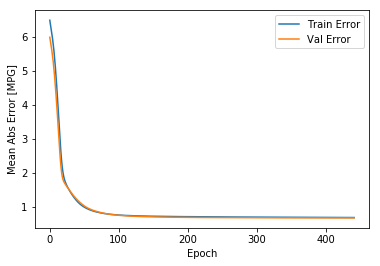

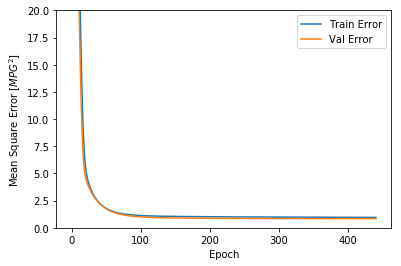

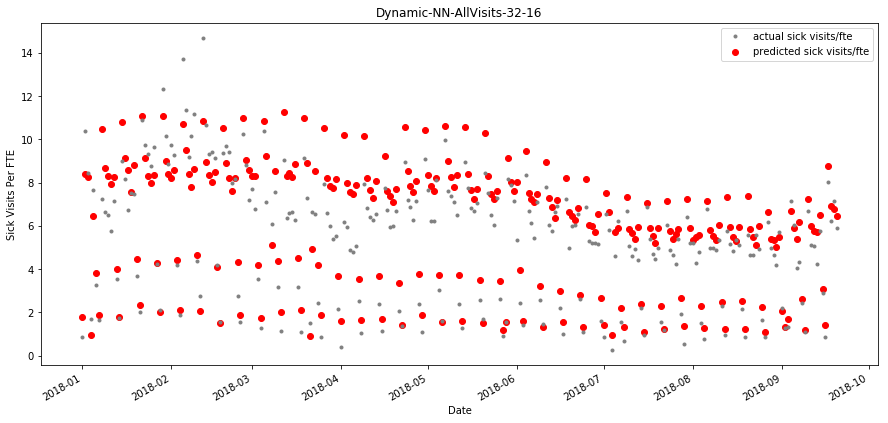

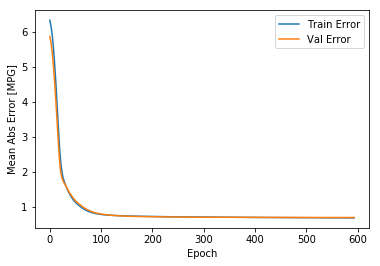

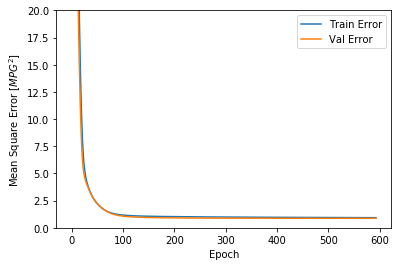

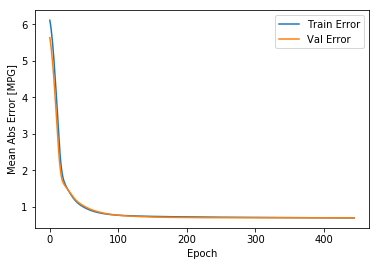

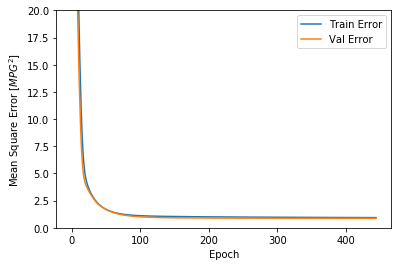

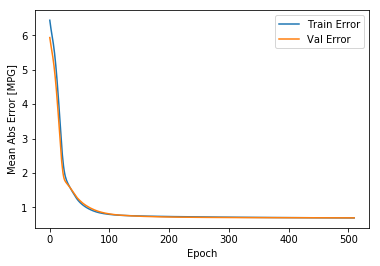

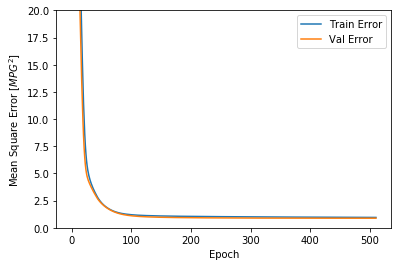

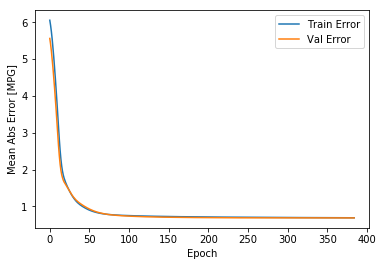

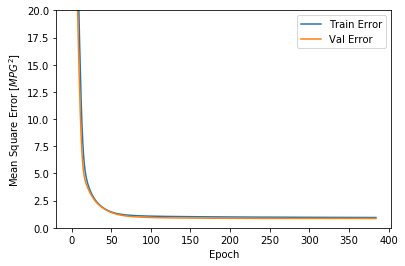

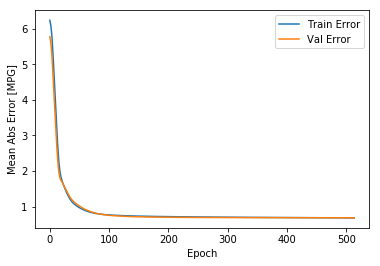

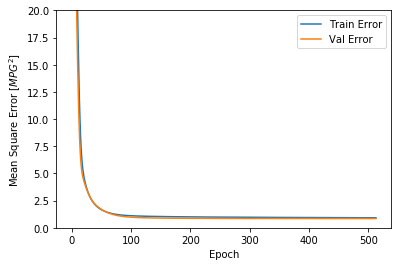

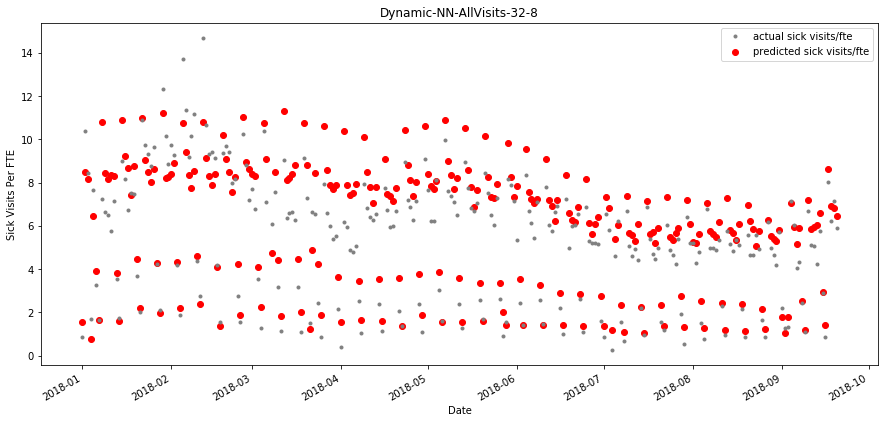

In [5]:
best_model = "64-64"
min_mse = 9999
for key, value in models.items():
    print(key)
    val_mses, _, _ = run_dynamic_nn(value, "Dynamic-NN-AllVisits-" + str(key),
                   BASE_FEATURES, ALL_VISITS_LABEL, epochs, patience, 5)
    print(val_mses)
    if np.mean(val_mses) < min_mse:
        min_mse = np.mean(val_mses)
        best_model = key
    print("Best model %s" % (best_model))
    print("Min Val MSE %.3f" % (min_mse))